<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/Proyecto_Portafolio_de_Inversion_(VF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=6a657d4390d902101ee1fdd3a24830e3134bd00feda0502ac6fbc4dc75fc2c0a
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

[*********************100%***********************]  15 of 15 completed


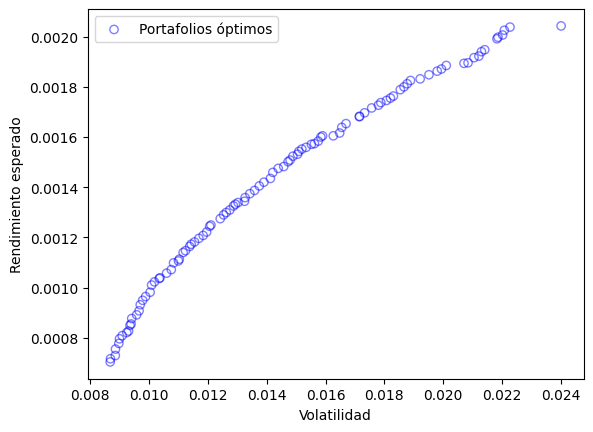

   Ticker  Num Acciones  Inversión ($)
12     MA            15    4096.950073
10     PG            21    2340.030006
3    AMZN           130    1286.999950
14      F            14    1198.819962
6     JPM             3     744.359985
5    NVDA             1     163.130005
4    TSLA             1     162.240005
1    MSFT             0       0.000000
0    AAPL             0       0.000000
2   GOOGL             0       0.000000
7       V             0       0.000000
9     WMT             0       0.000000
8     JNJ             0       0.000000
11    DIS             0       0.000000
13   NFLX             0       0.000000

Total invertido: $9992.53


In [7]:
# Definir tickers de 16 acciones (agregamos una más barata para compensar dinero sobrante)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT", "PG", "DIS", "MA", "NFLX", "F"]  # Se agregó Ford (F) como opción más barata

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

# Descargar datos de cierre
datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy()

# Obtener precios actuales
precios_actuales = datos.iloc[-1]

# Calcular rendimientos diarios
rend = datos.pct_change().dropna()

# Calcular media de rendimientos y matriz de covarianza
r = rend.mean().values
Cov = rend.cov().values

# Definir problema de optimización
class Portafolio(Problem):
    def __init__(self, mu, cov, precios, capital_total):
        self.mu = mu
        self.cov = cov
        self.precios = precios
        self.capital_total = capital_total
        super().__init__(n_var=15, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        rendimiento = x @ self.mu
        riesgo = np.sqrt(np.einsum('ij,jk,ik->i', x, self.cov, x))

        # Convertir pesos a inversión en dólares
        distribucion = x * self.capital_total

        # Asegurar que las inversiones correspondan a múltiplos del precio de las acciones
        num_acciones = np.floor(distribucion / self.precios.values)
        distribucion_real = num_acciones * self.precios.values

        # Ajustar para usar más capital disponible
        dinero_restante = self.capital_total - np.sum(distribucion_real)
        if dinero_restante > 0:
            accion_barata_idx = np.argmin(self.precios.values)
            num_acciones[accion_barata_idx] += np.floor(dinero_restante / self.precios.iloc[accion_barata_idx])
            distribucion_real = num_acciones * self.precios.values

        out["F"] = [riesgo, -rendimiento]
        out["G"] = np.abs(np.sum(x, axis=1) - 1.0) - 0.01

# Resolver problema
capital_total = 10000
problem = Portafolio(r, Cov, precios_actuales, capital_total)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 300), seed=1, verbose=False)

# Obtener soluciones óptimas
X, F = res.opt.get("X", "F")
F[:, 1] *= -1  # Invertir rendimiento

# Graficar la frontera eficiente
plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.legend()
plt.show()

# Obtener el portafolio con mejor beneficio
mejor_idx = np.argmax(F[:, 1])
mejor_pesos = X[mejor_idx]

distribucion = mejor_pesos * capital_total
num_acciones = np.floor(distribucion / precios_actuales.values)
distribucion_real = num_acciones * precios_actuales.values

# Ajustar para usar todo el capital disponible
dinero_restante = capital_total - np.sum(distribucion_real)
if dinero_restante > 0:
    accion_barata_idx = np.argmin(precios_actuales.values)
    num_acciones[accion_barata_idx] += np.floor(dinero_restante / precios_actuales.iloc[accion_barata_idx])
    distribucion_real = num_acciones * precios_actuales.values

# Mostrar distribución de inversión
portafolio_optimo = pd.DataFrame({'Ticker': tickers, 'Num Acciones': num_acciones.astype(int), 'Inversión ($)': distribucion_real})
print(portafolio_optimo.sort_values(by='Inversión ($)', ascending=False))

# Mostrar el total invertido
total_inversion = distribucion_real.sum()
print("")
print(f"Total invertido: ${total_inversion:.2f}")